Here we implement the whole process where U is applied multiple times. We use TrotterQRTE to provide Quantum Circuit and run the QC in simulator and collect the evolved state to proceed.

In [1]:
import sys
print(sys.executable)

C:\Users\schauue\Anaconda3\python.exe


In [2]:
import numpy as np
import scipy
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector, state_fidelity, Operator
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit_aer import AerSimulator
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
import matplotlib.pyplot as plt
from scipy.linalg import expm, cosm
import warnings
import sys
import functools
import scipy as sc
from qiskit.visualization import plot_histogram

In [3]:
initial_state = Statevector.from_label('00000')
step = 10
time = 1
time_step = 20
nqubits = 4
periodic = True
J = 1/np.sqrt(2)
def get_hamiltonian_y(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZY', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZY', [nqubits, 1, 0], J)]
        X_tuples = [("XY", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()


def get_hamiltonian_i(nqubits, J, periodic):
    nqubits = nqubits - 1
    if periodic==False:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    else:
        ZZ_tuples = [('ZZI', [i, i+1, 0], J) for i in range(1, nqubits)]
        ZZ_tuples += [('ZZI', [nqubits, 1, 0], J)]
        X_tuples = [("XI", [i, 0], J) for i in range(1, nqubits+1)]
        hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits+1)
    return hamiltonian.simplify()

def get_hamiltonian(nqubits, J):
    ZZ_tuples = [('ZZ', [i, i+1], J) for i in range(nqubits-1)]
    ZZ_tuples += [('ZZ', [nqubits-1, 0], J)]
    X_tuples = [("X", [i], J) for i in range(nqubits)]
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=nqubits)
    return hamiltonian.simplify()

In [4]:
## calculate exp based on un-scaled hamiltonian
hamiltonian = get_hamiltonian(4, 1/np.sqrt(2))
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**4)) / (emax - emin) ## scale H

#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian = Operator(hamiltonian)
hamiltonian = SparsePauliOp.from_operator(hamiltonian)
initial_state = Statevector.from_label("00000")
final_time = np.pi/2 #time
time_step = 10 #time_step
normalization_factor = SparsePauliOp.from_operator(Operator(np.kron(projector2, np.eye(2**nqubits))))

# Exact parts
exact_times = np.linspace(0, final_time, 101)
# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * np.kron(projector, H_array))) for time in exact_times]
exact_energy = np.real([sv.expectation_value(hamiltonian)/(sv.data.conj().dot(normalization_factor.to_matrix()).dot(sv.data)) for sv in exact_evolution])

##Trotter parts
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[hamiltonian, normalization_factor],)
trotter= TrotterQRTE(SuzukiTrotter(order=2), num_timesteps=time_step, estimator=Estimator())
result = trotter.evolve(problem)

print(exact_evolution[-1])
print(Statevector(result.evolved_state).data[:2**4])

Statevector([ 1.66883523e-01+0.j, -1.26455172e-01+0.j, -1.26455172e-01+0.j,
             -1.19416557e-02+0.j, -1.26455172e-01+0.j, -1.50275560e-02+0.j,
             -1.19416557e-02+0.j,  2.53688041e-03+0.j, -1.26455172e-01+0.j,
             -1.19416557e-02+0.j, -1.50275560e-02+0.j,  2.53688041e-03+0.j,
             -1.19416557e-02+0.j,  2.53688041e-03+0.j,  2.53688041e-03+0.j,
              2.73740019e-04+0.j,  9.42335810e-01+0.j,  6.58790795e-02+0.j,
              6.58790795e-02+0.j, -1.81134563e-02+0.j,  6.58790795e-02+0.j,
             -1.50275560e-02+0.j, -1.81134563e-02+0.j, -2.07101193e-03+0.j,
              6.58790795e-02+0.j, -1.81134563e-02+0.j, -1.50275560e-02+0.j,
             -2.07101193e-03+0.j, -1.81134563e-02+0.j, -2.07101193e-03+0.j,
             -2.07101193e-03+0.j,  4.14091845e-04+0.j],
            dims=(2, 2, 2, 2, 2))
[ 0.1668503 -1.74677948e-16j -0.12641993+1.74113532e-16j
 -0.12641993-3.21912645e-17j -0.01194745-3.03918961e-17j
 -0.12641993-7.37842891e-17j -0.0150

In [63]:
nqubits = 4
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits, J)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
initial_state = Statevector.from_label("0000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 1
step = 20
## 1st order
def construct_trotter_circuit(H, time, nqubits, order, time_step):
    if order == 1:
        formular = LieTrotter(reps=time_step)
    else:
        formular = SuzukiTrotter(order=order, reps=time_step)
    trotter_step_first_order = PauliEvolutionGate(H, time, synthesis=formular)
    circuit = QuantumCircuit(nqubits+1)
    circuit.append(trotter_step_first_order, range(nqubits+1))
    #circuit = circuit.decompose(reps=2)
    return circuit

def select_sim(error_rate):
    noise_model = NoiseModel()
    error = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
    error1 = depolarizing_error(error_rate*10, 2)
    noise_model.add_all_qubit_quantum_error(error1,'cx')
    sim_d = AerSimulator(noise_model=noise_model)
    if error_rate==0:
        simulator = AerSimulator()
    else:
        simulator = sim_d
    return simulator

def unitary_trotter(H, time, nqubits, order, time_step, error_rate, step):
    simulator = select_sim(error_rate)
    expectation_list = []
    statevector = initial_state.data
    for i in range(step):
        qc = QuantumCircuit(nqubits+1)
        qc.initialize(statevector, range(nqubits))
        circuit_temp = construct_trotter_circuit(H, time, nqubits, order, time_step)
        qc = qc.compose(circuit_temp, range(nqubits+1))
        #qc = qc.decompose(reps=2)
        qc.save_statevector()
        circuit = transpile(qc, simulator)
        result = simulator.run(circuit).result().data(0)['statevector']
        new_state = result.data#[:2**nqubits]
        # Print the statevector at each step for debugging
        #print(f"Step {i}: Statevector = {statevector}")
        expectation = (new_state.conj().T.dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
        expectation_list.append(expectation)
        # Print the expectation value at each step for debugging
        #print(f"Step {i}: Expectation = {expectation}")
        statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])
    return expectation_list

expectation_1 = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
print(expectation_1)





[(-0.1311875556086449-4.065097352469494e-31j), (-0.8385795032783061-3.050068550797252e-30j), (-1.240231235697268+0j), (-1.5292773514361944+0j), (-1.7911991870179411+8.396710584379985e-30j), (-2.0485926828653818+0j), (-2.2977007411580317+0j), (-2.5283970056240377+0j), (-2.732575039559521+0j), (-2.9066308708380126+0j), (-3.0510001482217626+0j), (-3.1686416619069107-5.399769263682191e-29j), (-3.2635766996250357+0j), (-3.339904899228537+0j), (-3.4012982491036388+0j), (-3.4508241087272147-1.0391970884193142e-28j), (-3.4909473691181883+0j), (-3.523609139179171+5.149157996743898e-29j), (-3.5503251312873054+0j), (-3.5722776500485662+0j)]


In [55]:
order = 2
expectation_2 = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
print(expectation_2)

[(-0.15710361697988287+0j), (-0.8748908196004918+0j), (-1.2924354031153027+0j), (-1.6010687168158888+8.80493611774758e-30j), (-1.8841008923702443+1.6601716796859973e-29j), (-2.161165613784872+0j), (-2.4257549129470846+0j), (-2.6661183623895854+0j), (-2.8739649541056664+0j), (-3.0465964118274673+0j), (-3.185829100642089-5.409491932699456e-29j), (-3.2959827623706466+0j), (-3.3821752960828744+0j), (-3.4492881952620045+0j), (-3.5015053253207657-1.0343818572495767e-28j), (-3.5422062272523274+0j), (-3.574031718374456+0j), (-3.5990100992175975+0j), (-3.6186881304817695+0j), (-3.6342444449022335+0j)]


In [56]:
order = 4
expectation_4 = unitary_trotter(H, time, nqubits, order, time_step, error_rate, step)
print(expectation_4)

[(-0.15726076768353137-4.2475068867122824e-30j), (-0.8749572915538519+0j), (-1.2924784699554444+0j), (-1.601111731096789-3.521789841771068e-29j), (-1.8841462365940402+0j), (-2.161208623612038+0j), (-2.4257918067577693+0j), (-2.6661477793321477+0j), (-2.873987148185999+0j), (-3.04661218876919+2.2093673071849273e-28j), (-3.185839218177621-2.163768155556817e-28j), (-3.2959877825594566+0j), (-3.382175655911205-2.103001296168825e-28j), (-3.4492843126317485+0j), (-3.5014976635902486+0j), (-3.542195310125195+4.11533260169867e-28j), (-3.5740181124744703+0j), (-3.5989943835184603+0j), (-3.618670865632182+0j), (-3.634226148980739-4.068012291292712e-28j)]


## Exact matrix exponential

In [65]:
nqubits = 4
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
step = 20
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
initial_state = Statevector.from_label("0000")
expectation_exact = []
simulator = AerSimulator()
statevector = initial_state.data
for i in range(step):
    U = expm(-1.0j * time * np.kron(projector, H_array))
    qc = QuantumCircuit(nqubits+1)
    qc.initialize(statevector, range(nqubits))
    qc.unitary(U, range(nqubits+1))
    qc.decompose(reps=2)
    qc.save_statevector()
    result = simulator.run(qc).result().data(0)['statevector']
    new_state = result.data#[:2**nqubits]
    expectation = (new_state.conj().dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
    expectation_exact.append(expectation)
    statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])

    print(expectation)






(-0.15726074754010833+0j)
(-0.8749572744784655+0j)
(-1.2924784549832422+0j)
(-1.6011117167037432+0j)
(-1.8841462228970876+0j)
(-2.1612086115559213+0j)
(-2.4257917971505303+0j)
(-2.6661477724518554+0j)
(-2.8739871438099933+0j)
(-3.0466121863911635+0j)
(-3.185839217225165+0j)
(-3.2959877825285626+0j)
(-3.3821756564172407+0j)
(-3.4492843134085867+0j)
(-3.501497664467486+0j)
(-3.542195311001425+0j)
(-3.574018113294422+0j)
(-3.598994384255984+0j)
(-3.618670866278594+0j)
(-3.6342261495372314+0j)


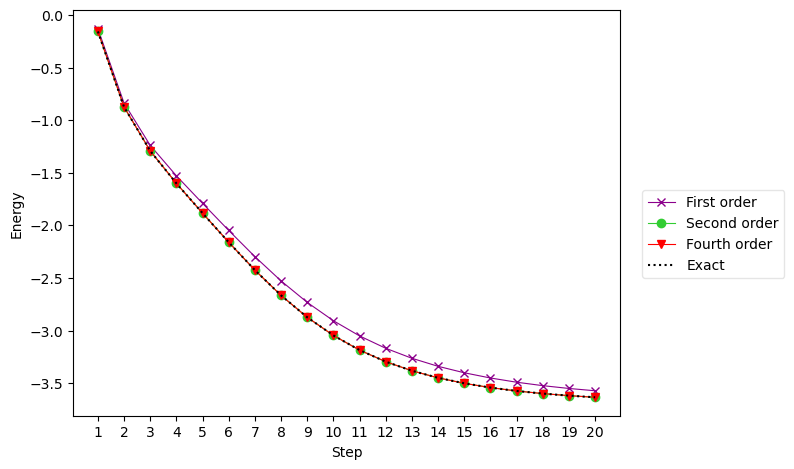

In [71]:
fig, axes = plt.subplots()
x = list(range(1, step+1))  # includes initial state
axes.plot(
    x, expectation_1, label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes.plot(
    x, expectation_2, label="Second order", marker="o", c="limegreen", ls="-", lw=0.8
)
axes.plot(
    x, expectation_4, label="Fourth order", marker="v", c="r", ls="-", lw=0.8
)
axes.plot(x, expectation_exact, c="k", ls=":", label="Exact")
legend = fig.legend(
    *axes.get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
axes.set_xticks(np.arange(min(x), max(x) + 1, 1))
axes.set_xlabel('Step')
axes.set_ylabel('Energy')
fig.tight_layout()

8 qubits

Nqubits=6 and use trotter to construct circuit and see whether it speeds up than qc.unitary(U)

In [77]:
nqubits = 8
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
step = 20
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
initial_state = Statevector.from_label("00000000")
expectation_exact = []
simulator = AerSimulator()
statevector = initial_state.data
for i in range(step):
    U = expm(-1.0j * time * np.kron(projector, H_array))
    qc = QuantumCircuit(nqubits+1)
    qc.initialize(statevector, range(nqubits))
    qc.unitary(U, range(nqubits+1))
    qc.decompose(reps=2)
    qc.save_statevector()
    result = simulator.run(qc).result().data(0)['statevector']
    new_state = result.data#[:2**nqubits]
    expectation = (new_state.conj().dot(hamiltonian1.to_matrix())).dot(new_state)/(new_state.conj().T.dot(hamiltonian2).dot(new_state))
    expectation_exact.append(expectation)
    statevector = new_state[:2**nqubits]/np.linalg.norm(new_state[:2**nqubits])

    print(expectation)

KeyboardInterrupt: 

In [75]:
nqubits = 8
J = 1/np.sqrt(2)
hamiltonian = get_hamiltonian(nqubits, J)
H_array = hamiltonian.to_matrix()
eval, _ = np.linalg.eigh(H_array)
# print(eval)
emin = eval[0]
emax = eval[-1]
H_array = (H_array - emin * np.eye(2**nqubits)) / (emax - emin) ## scale H
final_time = np.pi/2 #time
time = final_time
time_step = 10 #time_step
initial_state = Statevector.from_label("0000")
#H = get_hamiltonian_y(5, 1/np.sqrt(2), True)
projector = np.array([[0, -1.0j],
                     [1.0j, 0]])
H = Operator(np.kron(projector, H_array))
H = SparsePauliOp.from_operator(H)
projector2 = np.array([[1, 0],
                     [0, 0]]) ## for expectation
hamiltonian1 = np.kron(projector2, get_hamiltonian(4, 1/np.sqrt(2)).to_matrix())
hamiltonian1 = Operator(hamiltonian1)
hamiltonian1 = SparsePauliOp.from_operator(hamiltonian1)
hamiltonian2 = np.kron(projector2, np.eye(2**nqubits))
error_rate = 0
order = 1
step = 20

circ = QuantumCircuit(nqubits+1)
U = expm(-1.0j * time * np.kron(projector, H_array))
circ.unitary(U, range(nqubits+1))
circ.save_statevector()
simulator.run(qc).result()

Result(backend_name='aer_simulator', backend_version='0.13.3', qobj_id='', job_id='ebbc9508-43db-48a3-a9d2-8f4cee468e12', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(statevector=Statevector([ 0.10235339+0.j, -0.21260232+0.j, -0.21260232+0.j,
              0.18635546+0.j, -0.21260232+0.j,  0.50347622+0.j,
              0.18635546+0.j, -0.19257463+0.j, -0.21260232+0.j,
              0.18635546+0.j,  0.50347622+0.j, -0.19257463+0.j,
              0.18635546+0.j, -0.19257463+0.j, -0.19257463+0.j,
              0.0857619 +0.j,  0.01574892+0.j, -0.0221168 +0.j,
             -0.0221168 +0.j,  0.02647876+0.j, -0.0221168 +0.j,
             -0.03123427+0.j,  0.02647876+0.j, -0.00654422+0.j,
             -0.0221168 +0.j,  0.02647876+0.j, -0.03123427+0.j,
             -0.00654422+0.j,  0.02647876+0.j, -0.00654422+0.j,
             -0.00654422+0.j,  0.00284817+0.j],
            dims=(2, 2, 2, 2, 2))), header=QobjExperimentHeader(creg_siz